# Классификатор

In [60]:
import pandas as pd
import torch
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression



In [61]:
batch_size = 8096

In [ ]:
wine_url = "https://nagornyy.me/datasets/wine_reviews.csv.zip"
df_wine = pd.read_csv(wine_url)
# удаляем вина без рейтинга или без цены
df_wine.dropna(subset=["points", "price"], inplace=True)
y_bin = (df_wine.points > df_wine.points.median()).values.reshape(-1, 1)
X = np.log(df_wine.price.values).reshape(-1, 1)

In [63]:
log_reg_sklearn = LogisticRegression()
log_reg_sklearn.fit(X, y_bin);
predicted = log_reg_sklearn.predict(X)
roc_auc_score(y_bin, predicted)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7203256049503224

In [44]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [45]:
def log_reg_model(X, w, b):
    return sigmoid(X @ w.t() + b)

$$binary \ cross \ entropy= \frac{-1}{n} \sum_{n}y\cdot ln(\hat{y})+(1-y)\cdot ln(1-\hat{y})$$

In [46]:
# criterion = nn.CrossEntropyLoss()

def binary_cross_entropy(true, predicted):
    return -1 / len(true) * (true * predicted.log() + (1 - true) * (1 - predicted).log()).sum()

In [84]:
y_tensor = torch.from_numpy(y_bin).float()
X_tensor = torch.from_numpy(X).float()

In [85]:
# по мотивами Kaiming initialization
w = torch.randn(y_bin_tensor.shape[1], X_tensor.shape[1]) / math.sqrt(2 / y_bin_tensor.shape[1])
b = torch.zeros(y_bin_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True);

learning_rate = 0.01

for i in range(100):
    predictions = log_reg_model(X_tensor, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_bin_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

predictions = log_reg_model(X_tensor, w, b)
roc_auc_score(y_bin, predictions.detach().numpy())

0.8127689987977705

In [86]:
0.8127689987977705

0.8127689987977705

## Регрессия с категориальными переменными

In [648]:
categorical_features = [
    "country",
    "region_1",
    "region_2",
    "variety",
    "winery",
    "province"
]
X_sparse = pd.get_dummies(
    df_wine[["price", "points"] + categorical_features],
    columns=categorical_features,
    drop_first=True,
    dummy_na=True
)
X_sparse.shape

(18198, 8440)

In [649]:
X_sparse_tensor = torch.from_numpy(X_sparse.values).float()

In [364]:
# по мотивами Kaiming initialization
w = torch.randn(y_tensor.shape[1], X_sparse_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[1])
b = torch.zeros(y_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True);

for i in range(100):
    predictions = log_reg_model(X_sparse_tensor, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

predictions = log_reg_model(X_sparse_tensor, w, b)
roc_auc_score(y_bin_train, predictions.detach().numpy())

## Взаимодействие признаков

In [38]:
from sklearn.preprocessing import PolynomialFeatures

In [39]:
poly2 = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [40]:
interactions2 = poly2.fit_transform(X_sparse.loc[:, "country_Australia":].values)

MemoryError: Unable to allocate array with shape (18198, 35604141) and data type float64

## FM

$$\begin{split}\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= `\frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}\end{split}$$

$$\sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \textbf v_i, \textbf v_j \rangle x_i x_j = 
\frac{1}{2} \sum_{f=1}^{k} \Big( \big(\sum_{i=1}^{n} v_f^{(i)} x_i \big)^2 - \sum_{i=1}^{n}v_f^{(i) 2} x_i^2 \Big) = 
\frac{1}{2} \sum_{f=1}^{} \Big( S_{1,f}^2 - S_{2,f} \Big) =
\frac{1}{2} \Big( S_{1}^2 - S_{2} \Big),
$$

In [644]:
bin_features = X_sparse.columns[(X_sparse.nunique() == 2)]
X_sparse = X_sparse[bin_features]
X_sparse_tensor = torch.from_numpy(X_sparse.values).float()

In [647]:
bin_features.shape, X_sparse.shape

((8434,), (18198, 8434))

In [697]:
!ls /app

2weeks-granulation		 nohup.out
2weeks-granulation-chernobrovov  nuxt-pwp
adhoc				 polina
base-multilabel-clf		 recmetrics
blog				 rec-similar-dev
course-v3			 recsys-rubbles-2019
crm-sku				 test-brands-as-input
current-baseline-model		 tmp
dask-worker-space		 topic-modelling
deep-fm				 two-step-recsys-proxy
docs				 two-step-recsys-proxy-2weeks
get-data			 two-step-recsys-with-cats
job-interview			 two-step-recsys-with-resampling
jupyter_local.log		 two-step-xdeep-2month_cat
modules				 x5


In [741]:
train_df = pd.read_csv('/app/tmp/dota_train_binary_heroes.csv.zip', index_col='match_id_hash').astype(np.float32)
test_df = pd.read_csv('/app/tmp/dota_train_binary_heroes.csv.zip', index_col='match_id_hash').astype(np.float32)
target = pd.read_csv('/app/tmp/train_targets.csv.zip', index_col='match_id_hash')
y = target['radiant_win'].values.astype(np.float32)
y = y.reshape(-1,1)

In [742]:
train_df.shape, y.shape

((39675, 230), (39675, 1))

In [743]:
y_bin_train_tensor = torch.from_numpy(y)
X_sparse_tensor = torch.from_numpy(train_df.values)

In [763]:
def fm_model(X, V, w, b):
    s1 = ((X @ V) ** 2).sum(dim=1, keepdim=True)
    s2 = ((X ** 2) @ (V ** 2)).sum(dim=1, keepdim=True)
    interaction_term = (s1 - s2) / 2
    
    linear_term = lin_reg_model(X, w, b)
    return sigmoid(linear_term + interaction_term)

In [764]:
# по мотивами Kaiming initialization
w = torch.randn(y_bin_train_tensor.shape[1], X_sparse_tensor.shape[1]) / math.sqrt(2 / y_bin_train_tensor.shape[1])
b = torch.zeros(y_bin_train_tensor.shape[1])

k = 5
V = torch.randn(X_sparse_tensor.shape[1], k)

w.requires_grad_(True)
b.requires_grad_(True)
V.requires_grad_(True);

In [765]:
predictions = fm_model(torch.from_numpy(train_df.values), V, w, b)

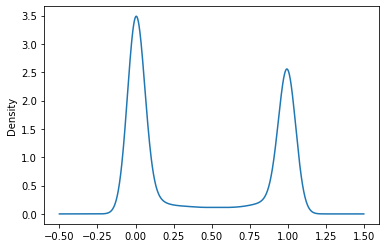

In [766]:
pd.Series(predictions.squeeze().detach().numpy()).plot(kind="kde")

In [767]:
binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))

tensor(0.7896, grad_fn=<MulBackward0>)

In [768]:
for i in range(100):
    predictions = fm_model(X_sparse_tensor, V, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_bin_train_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        V -= V.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()
        V.grad.zero_()
    if i % 20 == 0:
        print(i, loss)

0 tensor(0.7896, grad_fn=<MulBackward0>)
20 tensor(0.7895, grad_fn=<MulBackward0>)
40 tensor(0.7893, grad_fn=<MulBackward0>)
60 tensor(0.7892, grad_fn=<MulBackward0>)
80 tensor(0.7891, grad_fn=<MulBackward0>)


In [769]:
predictions = fm_model(X_sparse_tensor, V, w, b)

In [770]:
roc_auc_score(y_bin_train_tensor.squeeze().detach().numpy(), predictions.squeeze().detach().numpy())

0.5035172323360353

In [773]:
class TorchFM(nn.Module):
    def __init__(self, n=None, k=None):
        super().__init__()
        # Initially we fill V with random values sampled from Gaussian distribution
        # NB: use nn.Parameter to compute gradients
        self.V = nn.Parameter(torch.randn(n, k),requires_grad=True)
        self.lin = nn.Linear(n, 1)

        
    def forward(self, x):
        out_1 = torch.matmul(x, self.V).pow(2).sum(1, keepdim=True) #S_1^2
        out_2 = torch.matmul(x.pow(2), self.V.pow(2)).sum(1, keepdim=True) # S_2
        
        out_inter = 0.5*(out_1 - out_2)
        out_lin = self.lin(x)
        out = out_inter + out_lin
        
        return out

In [776]:
from torch import optim

learning_rate = 0.01
epochs = 1000
model = TorchFM(X_sparse_tensor.shape[1], 5)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient
    # from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    predictions = model(X_sparse_tensor)

    # get loss for the predicted output
    loss = criterion(predictions, y_bin_train_tensor)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 5.944705963134766
epoch 100, loss 5.717885494232178
epoch 200, loss 5.506598472595215
epoch 300, loss 5.308901309967041
epoch 400, loss 5.123404026031494
epoch 500, loss 4.949056625366211
epoch 600, loss 4.785022735595703
epoch 700, loss 4.63062047958374
epoch 800, loss 4.48528528213501
epoch 900, loss 4.348516941070557


In [778]:
predictions = model(X_sparse_tensor)
roc_auc_score(y_bin_train_tensor.squeeze().detach().numpy(), predictions.squeeze().detach().numpy())

0.5009520269804396

In [16]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [20]:
log_reg_sklearn = LogisticRegression(solver="liblinear")
log_reg_sklearn.fit(X, y);
predicted = log_reg_sklearn.predict(X)
roc_auc_score(y, predicted)

0.9543760900586651

In [116]:
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()
X_tensor = torch.from_numpy(X).float()

# по мотивами Kaiming initialization
w = torch.randn(y_tensor.shape[1], X_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[1])
b = torch.zeros(y_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True);

for i in range(10000):
    predictions = log_reg_model(X_tensor, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

predictions = log_reg_model(X_tensor, w, b)
roc_auc_score(y, predictions.detach().numpy())

0.5

In [117]:
learning_rate

0.01

In [124]:
y_tensor.shape[1]

1

In [11]:
from torch import nn
from torch.autograd import Variable
from torch.functional import F

In [24]:
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()
X_tensor = torch.from_numpy(X).float()

In [6]:
from torchvision import datasets, transforms
from torch.nn import functional as F

In [7]:
import torch
torch.__version__

'1.4.0'

In [26]:
X_tensor.shape, y.shape

(torch.Size([569, 30]), (569,))

In [57]:
class LogisticRegressionTorch(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = torch.nn.Linear(30, 1)
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = LogisticRegressionTorch()
criterion = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    predictions = model(X_tensor)
    # Compute Loss
    loss = criterion(predictions, y_tensor)
    # Backward pass
    loss.backward()
    optimizer.step()

predictions = model(X_tensor)
roc_auc_score(y, predictions.detach().numpy())

0.5

In [59]:
# по мотивами Kaiming initialization
w = torch.randn(y_tensor.shape[1], X_tensor.shape[1])
b = torch.zeros(y_tensor.shape[1])

w.requires_grad_(True)
b.requires_grad_(True);

learning_rate = 0.1

for i in range(100):
    predictions = log_reg_model(X_tensor, w, b)
    loss = binary_cross_entropy(predictions, sigmoid(y_tensor))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

predictions = log_reg_model(X_tensor, w, b)
roc_auc_score(y, predictions.detach().numpy())

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [52]:
predictions

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      